# DIABETES PREDICTION

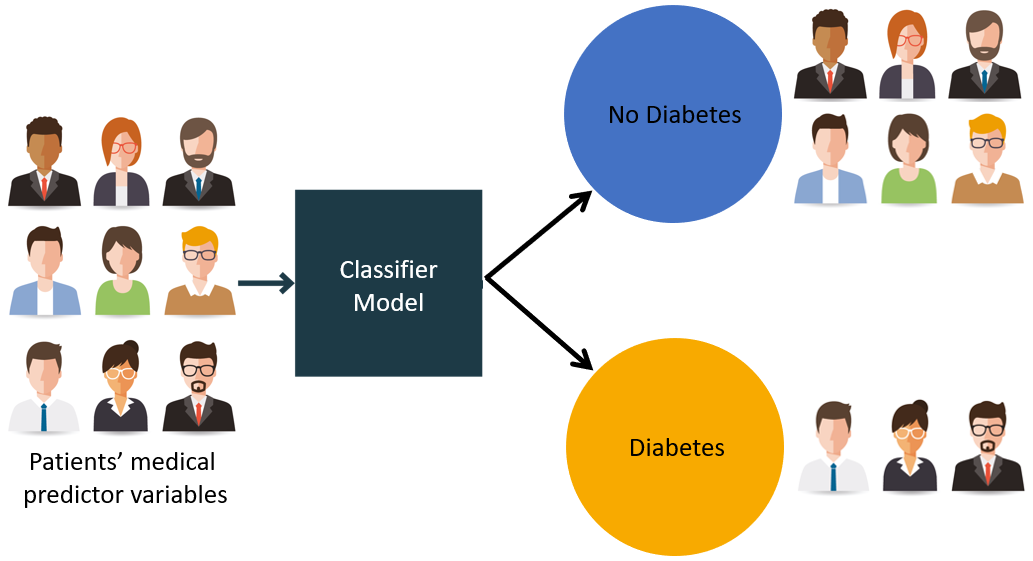

Görsel: https://jnyh.medium.com/building-a-machine-learning-classifier-model-for-diabetes-4fca624daed0

**Veri Seti Hakkında Bilgi:** ABD'deki Arizona Eyaleti'nin en büyük 5. şehri olan Phoenix şehrinde yaşayan 21
yaş ve üzerinde olan Pima Indian kadınları üzerinde yapılan diyabet araştırması için kullanılan verilerdir.
768 gözlem ve 8 sayısal bağımsız değişkenden oluşmaktadır. Hedef değişken "outcome" olarak belirtilmiş olup;
1 diyabet test sonucunun pozitif oluşunu,0 ise negatif oluşunu belirtmektedir.

**Değişkenler:**
Pregnancies – Hamilelik sayısı,Glucose – Glikoz değeri,SkinThickness – Cilt Kalınlığı,Insulin – 2 saatlik serum insülini (mu U/ml)
Blood Pressure – Kan Basıncı (Küçük tansiyon) (mm Hg),DiabetesPedigreeFunction– Aile öyküsüne dayalı olarak diyabet olasılığını puanlayan bir fonksiyon
Age – Yaş (yıl),Outcome– Hastalığa sahip (1) ya da değil (0)

**Amaç:** Özellikleri belirtildiğinde kişilerin diyabet hastası olup olmadıklarını tahmin edebilecek bir makine öğrenmesi
modeli geliştirmek.

**Yararlanılan kaynak**: https://bootcamp.veribilimiokulu.com/egitim/veri-bilimci-yetistirme-programi/

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, \
roc_auc_score, classification_report, confusion_matrix, plot_roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler,MinMaxScaler
import matplotlib.pyplot as plt

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 40)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 170)

In [ ]:
df=pd.read_csv("../input/diabetes-data-set/diabetes.csv")

VERİYE GENEL BAKIŞ

In [ ]:
df.head()

In [ ]:
df.isnull().sum()

Veri setinde bazı gözlemlerde insülin değerleri 0 olarak girilmiş. Bir kişinin insülin değerinin 0 olması mümkün değildir,anlaşılan insülin değerlerine bakılmayan kişilerin insülin değerleri, sıfır olarak girilmiş; bunlar nan olarak değiştirilir. Aynı sorunun olduğu diğer columnlarda da böyle bir değişiklik yapılır.

In [ ]:
df[["Glucose","BloodPressure","SkinThickness","Insulin","BMI"]] = df[["Glucose","BloodPressure","SkinThickness","Insulin","BMI"]].replace(0,np.NaN)

In [ ]:
df.isnull().sum()

EKSİK DEĞERLERİN DOLDURULMASI

Oluşan boş değerler,boş değerlerin 3 komşusuna bakılarak knn imputer ile doldurulur.

In [ ]:
from sklearn.impute import KNNImputer
scaler = RobustScaler()
dff = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
dff.head()

In [ ]:
imputer = KNNImputer(n_neighbors=3)
dff = pd.DataFrame(imputer.fit_transform(dff), columns=dff.columns)
dff.head()
dff.isnull().sum()

Boş değerleri knn ile doldurmak için öncelikle dataframe'in standartlaştırılması gerekir. Standartlaştırılan değerler boş değerler doldurulduktan sonra tekrar inverse.transform ile eski haline getirilir.
Gerçek değerlere göre feaature oluşturmak mantıklı olacağından bu işlem yapılır.

In [ ]:
df = pd.DataFrame(scaler.inverse_transform(dff), columns=dff.columns)

In [ ]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

In [ ]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

In [ ]:
df.describe().T

Veri seti küçük olduğundan aykırı değerlere herhangi bir işlem yapılmadı.

FEATURE ENGINEERING

In [ ]:
df["Age"].describe()

In [ ]:
df.loc[(df["Age"]<30),"new_Age"]="young"
df.loc[(df["Age"]>=30) & (df["Age"] <46),"new_Age"]="mature"
df.loc[(df["Age"]>=46),"new_Age"]="grownup+"

Bir kişinin glikoz değeri 140'tan yüksek ise risk grubundadır.

In [ ]:
df["Gli_risk"]=[1 if i>140 else 0 for i in df["Glucose"]]

Şeker hastalarının cildi kalınlaşır.Sayısal değer olduğundan ve belli bir metriğe indirgenemediğinden
bu şekilde bırakılır.

In [ ]:
df.loc[(df["Outcome"] == 1),"SkinThickness"].sort_values(ascending=False).describe().T

DiabetesPedigreeFunction: aile öyküsüne dayalı olarak diyabet olasılığını puanlayan bir işlev

In [ ]:
df["DiabetesPedigreeFunction"].describe()

In [ ]:
df.loc[df["DiabetesPedigreeFunction"]<0.33,"Genetics_risk"]="low"
df.loc[(df["DiabetesPedigreeFunction"]>=0.33) & (df["DiabetesPedigreeFunction"]<0.66),"Genetics_risk"]="high"
df.loc[(df["DiabetesPedigreeFunction"]>=0.66),"Genetics_risk"]="very high"

Vücut Kitle İndeksi (BMI)
BMI değeri 30'dan küçükse şeker hastası olma ihtimali düşük ama 30'u geçerse yüksek.

In [ ]:
df.loc[(df["BMI"]<30),"BMI_risk"]="low"
df.loc[(df["BMI"]>=30) & (df["BMI"]<35),"BMI_risk"]="high"
df.loc[(df["BMI"]>=35),"BMI_risk"]="very high"

Hamilelik sayısının artması da şeker hastası olma ihtimalini artırıyor

In [ ]:
df["Pregnancies"].nunique()

In [ ]:
df["Pregnancies"].unique()

Zaten aralarında bir sıralama olduğundan bu şekilde bırakılır.

BloodPressure kan basıncının yüksek olması da etkiliyor

In [ ]:
df["BloodPressure_risk"]=[1 if i>90 else 0 for i in df["BloodPressure"]]

İnsülin değerleri de risk durumuna göre 3 kategoriye ayrılır.

In [ ]:
df[df["Insulin"]>400][["Insulin","Outcome"]]

In [ ]:
df.loc[df["Insulin"]>400,"Ins_risk"]="very high"
df.loc[(df["Insulin"]<=400) & (df["Insulin"]>200),"Ins_risk"]="high"
df.loc[(df["Insulin"]<=200),"Ins_risk"]="usual"

Yeni columnlar oluştuğundan tekrar kategorik-numerik ayrımı yapılır.

In [ ]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)
binary_cols = [col for col in df.columns if df[col].dtype not in [int, float]
               and df[col].nunique() == 2]

Encoding işlemleri yapılır.

In [ ]:
for i in binary_cols:
    df[i] = labelencoder.fit_transform(df[i])

In [ ]:
ohe_cols = [col for col in df.columns if 10 >= df[col].nunique() > 2]

In [ ]:
df=pd.get_dummies(df, columns=ohe_cols, drop_first=True)

Nadir olan durumlar 0.01 oranında görmezden gelinir.

In [ ]:
def rare_encoder(dataframe, rare_perc):
    temp_df = dataframe.copy()

    rare_columns = [col for col in temp_df.columns if temp_df[col].dtypes == 'O'
                    and (temp_df[col].value_counts() / len(temp_df) < rare_perc).any(axis=None)]

    for var in rare_columns:
        tmp = temp_df[var].value_counts() / len(temp_df)
        rare_labels = tmp[tmp < rare_perc].index
        temp_df[var] = np.where(temp_df[var].isin(rare_labels), 'Rare', temp_df[var])

    return temp_df

In [ ]:
df=rare_encoder(df, 0.01)

Modele katmak için standartlaştırma işlemi yapıLır veri seti küçük olduğundan ve çok uç bir değer olmadığından
aykırı değerlere herhangi bir işlem yapılmadı bu yüzden robust scaler kullanıldı.

In [ ]:
for col in num_cols:
    transformer = RobustScaler().fit(df[[col]])
    df[col] = transformer.transform(df[[col]])

In [ ]:
y = df["Outcome"]
X = df.drop(["Outcome"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.20, random_state=1)

log_model = LogisticRegression().fit(X_train, y_train)

In [ ]:
# tahmin'lerin oluşturulması ve kaydedilmesi
y_pred = log_model.predict(X_train)

In [ ]:
# sınıf olasılıkları
log_model.predict_proba(X_train)[0:10]

In [ ]:
# 1. sınıfa ait olma olasılıkları:
y_prob = log_model.predict_proba(X_train)[:, 1]

In [ ]:
y_pred = log_model.predict(X_train)
accuracy_score(y_train, y_pred)

In [ ]:
# Diğer metrikler için y_pred
y_pred = log_model.predict(X_test)

In [ ]:
# AUC Score için y_prob
y_prob = log_model.predict_proba(X_test)[:, 1]

In [ ]:
# CONFUSION MATRIX
def plot_confusion_matrix(y, y_pred):
    acc = round(accuracy_score(y, y_pred), 2)
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, fmt=".0f")
    plt.xlabel('y_pred')
    plt.ylabel('y')
    plt.title('Accuracy Score: {0}'.format(acc), size=10)
    plt.show()

In [ ]:
plot_confusion_matrix(y_test, y_pred)

Görsele bakıldığında gerçekte 0 olan 99 veri varmış bunun 88'i doğru tahmin edilmiş 11'i ise 1 olarak yanlış tahmin edilmiş.
Gerçekte 1 olan 55 veri varken bunların 36'sı doğru tahmin edilmiş 19'u ise 0 olarak yanlış tahmin edilmiş; buradan çıkarılacak sonuç model 0'ları tahmin ederken gösterdiği başarıyı 1'leri tahmin ederken gösteremiyor olur.

In [ ]:
#tahminlerin doğru tahmin edilme oranı
accuracy_score(y_test, y_pred)

In [ ]:
#Pozitif olarak tahmin edilenlerin doğru tahmin edilme oranlarını verir.
precision_score(y_test, y_pred)

In [ ]:
#Gerçekte pozitif olan durumların doğru tahmin edilme oranını verir.
recall_score(y_test, y_pred)

In [ ]:
f1_score(y_test, y_pred)

In [ ]:
roc_auc_score(y_test, y_prob)

In [ ]:
print(classification_report(y_test, y_pred))